## Config + model rebuild + load weights

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import cv2
import random
import pandas as pd

# ---------------- CONFIG ----------------
DATA_ROOT = Path("/kaggle/input/ham1000-segmentation-and-classification")
FULL_IMG_DIR = DATA_ROOT / "images"                     # full dermoscopic images
CROP_IMG_DIR = Path("/kaggle/input/ham10000-segment-data/ham_lesion_crops") # lesion crops
CSV_PATH = DATA_ROOT / "GroundTruth.csv"

MODEL_PATH = Path("/kaggle/input/db-larnet-model-outputs/ham_dualbranch_cls_outputs/best_dualbranch_cls_model.pth")

CLASS_NAMES = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]
NUM_CLASSES = len(CLASS_NAMES)
IMG_SIZE = 224
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# --------------- TRANSFORMS (match val) ---------------
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# --------------- DUAL-BRANCH MODEL (same as training) ---------------
class DualBranchResNet(nn.Module):
    """
    DB-LARNet:
      Branch A: full image -> ResNet-18 backbone
      Branch B: lesion crop -> ResNet-18 backbone
      Fuse: concat pooled features -> FC -> logits
    """
    def __init__(self, num_classes=7, pretrained=True):
        super().__init__()
        base_full = models.resnet18(
            weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        )
        base_crop = models.resnet18(
            weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        )

        # feature extractors (everything except FC)
        self.full_backbone = nn.Sequential(*list(base_full.children())[:-1])  # -> (B,512,1,1)
        self.crop_backbone = nn.Sequential(*list(base_crop.children())[:-1])  # -> (B,512,1,1)

        self.dropout = nn.Dropout(p=0.5)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, full_img, crop_img):
        full_feat = self.full_backbone(full_img)    # (B,512,1,1)
        crop_feat = self.crop_backbone(crop_img)    # (B,512,1,1)

        full_feat = full_feat.view(full_feat.size(0), -1)
        crop_feat = crop_feat.view(crop_feat.size(0), -1)

        fused = torch.cat([full_feat, crop_feat], dim=1)  # (B,1024)
        fused = self.dropout(fused)
        logits = self.classifier(fused)
        return logits

# load model
model = DualBranchResNet(num_classes=NUM_CLASSES, pretrained=False).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("Loaded DB-LARNet weights from:", MODEL_PATH)

# load labels (for picking IDs etc.)
df = pd.read_csv(CSV_PATH)
all_image_ids = df["image"].tolist()
print("Total images:", len(all_image_ids))

Device: cuda
Loaded DB-LARNet weights from: /kaggle/input/db-larnet-model-outputs/ham_dualbranch_cls_outputs/best_dualbranch_cls_model.pth
Total images: 10015


## Grad-CAM for each branch (full & crop)

In [2]:
# ================== GRAD-CAM CLASS ==================

class GradCAMBranch:
    """
    Grad-CAM for a specific branch in DB-LARNet
    (either full_backbone[7] or crop_backbone[7])
    """
    def __init__(self, model, target_layer, branch_name="full"):
        self.model = model
        self.target_layer = target_layer
        self.branch_name = branch_name

        self.gradients = None
        self.activations = None

        # hook onto target layer
        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, inflow, outflow):
        self.activations = outflow.detach()  # (B,C,H,W)

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()  # (B,C,H,W)

    def generate(self, full_tensor, crop_tensor, target_class=None):
        """
        full_tensor: (1,3,H,W)
        crop_tensor: (1,3,H,W)
        target_class: optional int. If None, use predicted class.
        returns: cam (H,W), class_idx
        """
        self.model.zero_grad()
        logits = self.model(full_tensor, crop_tensor)  # (1, num_classes)

        if target_class is None:
            target_class = logits.argmax(dim=1).item()

        score = logits[:, target_class]
        score.backward()

        grads = self.gradients      # (1,C,H,W)
        acts = self.activations     # (1,C,H,W)

        # GAP over spatial
        weights = grads.mean(dim=(2, 3), keepdim=True)  # (1,C,1,1)
        cam = (weights * acts).sum(dim=1, keepdim=False)  # (1,H,W) -> (H,W)
        cam = cam.squeeze(0)

        cam = F.relu(cam)
        cam -= cam.min()
        if cam.max() > 0:
            cam /= cam.max()

        return cam.cpu().numpy(), target_class


# In ResNet18 backbone, layer4 is index 7 in the Sequential:
# [0]=conv1,1=bn1,2=relu,3=maxpool,4=layer1,5=layer2,6=layer3,7=layer4,8=avgpool
full_layer4 = model.full_backbone[7]
crop_layer4 = model.crop_backbone[7]

gc_full = GradCAMBranch(model, full_layer4, branch_name="full")
gc_crop = GradCAMBranch(model, crop_layer4, branch_name="crop")

## Helper to overlay heatmap on image

In [3]:
def overlay_cam_on_image(img_pil, cam, alpha=0.5):
    """
    img_pil: original PIL image (RGB)
    cam: (H_cam, W_cam) numpy, [0,1]
    returns: overlay numpy uint8 (H,W,3)
    """
    img = np.array(img_pil).astype(np.float32) / 255.0
    h, w, _ = img.shape

    cam_resized = cv2.resize(cam, (w, h))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

    overlay = alpha * heatmap + (1 - alpha) * img
    overlay = np.clip(overlay, 0, 1)
    return (overlay * 255).astype(np.uint8)

## Visualize Grad-CAM

Visualizing ID: ISIC_0032529


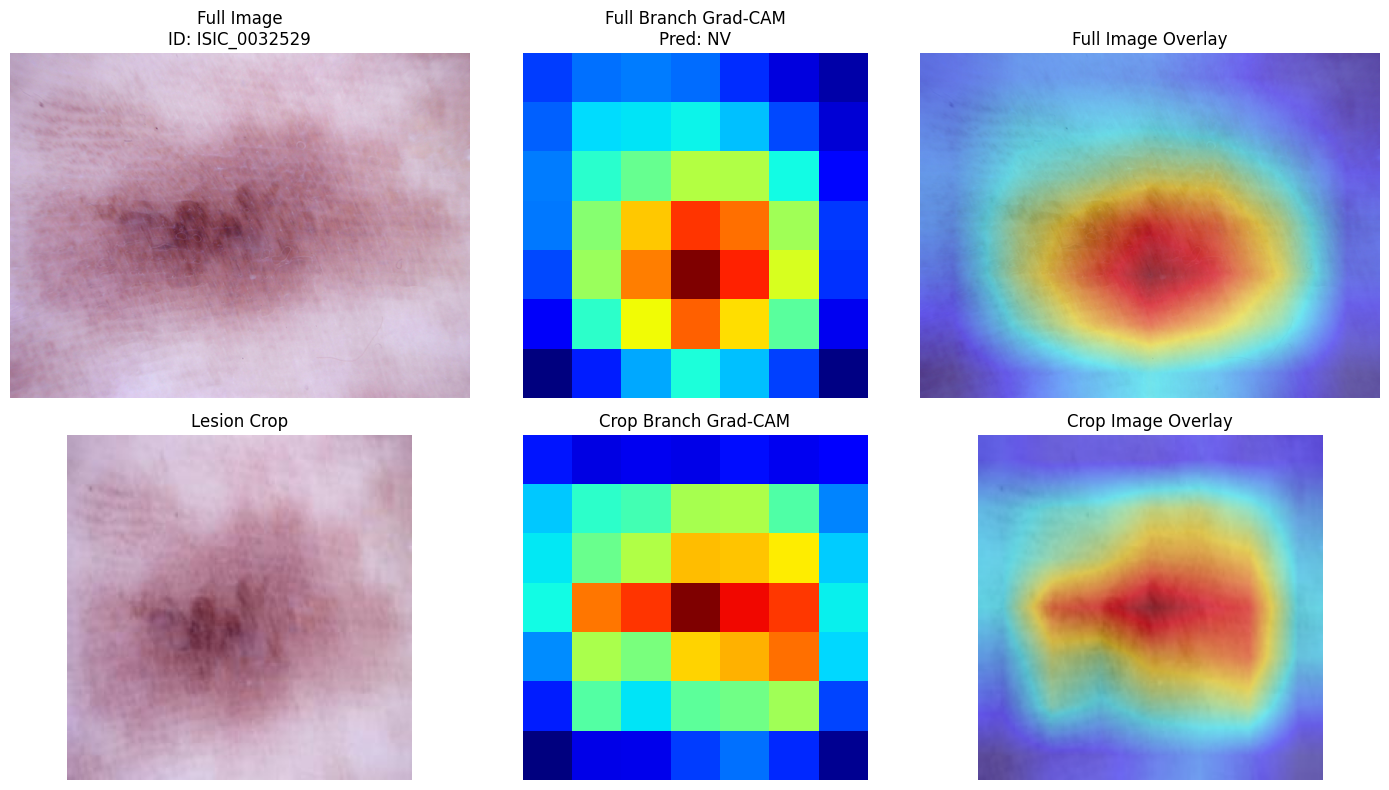

In [4]:
def load_full_and_crop(image_id):
    """Load original full image + crop, apply val_transform."""
    full_path = FULL_IMG_DIR / f"{image_id}.jpg"
    crop_path = CROP_IMG_DIR / f"{image_id}.jpg"

    full_pil = Image.open(full_path).convert("RGB")

    if crop_path.exists():
        crop_pil = Image.open(crop_path).convert("RGB")
    else:
        crop_pil = full_pil.copy()

    full_tensor = val_transform(full_pil).unsqueeze(0).to(DEVICE)
    crop_tensor = val_transform(crop_pil).unsqueeze(0).to(DEVICE)

    return full_pil, crop_pil, full_tensor, crop_tensor


def visualize_gradcam_for_id(image_id):
    full_pil, crop_pil, full_tensor, crop_tensor = load_full_and_crop(image_id)

    # Grad-CAM for both branches (same predicted class)
    cam_full, class_idx = gc_full.generate(full_tensor, crop_tensor, target_class=None)
    cam_crop, _        = gc_crop.generate(full_tensor, crop_tensor, target_class=class_idx)

    pred_class_name = CLASS_NAMES[class_idx]

    overlay_full = overlay_cam_on_image(full_pil, cam_full, alpha=0.5)
    overlay_crop = overlay_cam_on_image(crop_pil, cam_crop, alpha=0.5)

    # -------- PLOT --------
    plt.figure(figsize=(14, 8))

    # Full branch
    plt.subplot(2, 3, 1)
    plt.imshow(full_pil)
    plt.title(f"Full Image\nID: {image_id}")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(cam_full, cmap="jet")
    plt.title(f"Full Branch Grad-CAM\nPred: {pred_class_name}")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(overlay_full)
    plt.title("Full Image Overlay")
    plt.axis("off")

    # Crop branch
    plt.subplot(2, 3, 4)
    plt.imshow(crop_pil)
    plt.title("Lesion Crop")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(cam_crop, cmap="jet")
    plt.title("Crop Branch Grad-CAM")
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.imshow(overlay_crop)
    plt.title("Crop Image Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# ---------- RUN FOR ONE OR FEW SAMPLES ----------

# Option 1: specific ID
IMAGE_ID = random.choice(all_image_ids)   # or "ISIC_00xxxxx"
print("Visualizing ID:", IMAGE_ID)
visualize_gradcam_for_id(IMAGE_ID)

# Option 2: loop few random examples
# for _ in range(3):
#     img_id = random.choice(all_image_ids)
#     print("ID:", img_id)
#     visualize_gradcam_for_id(img_id)

ID: ISIC_0026149


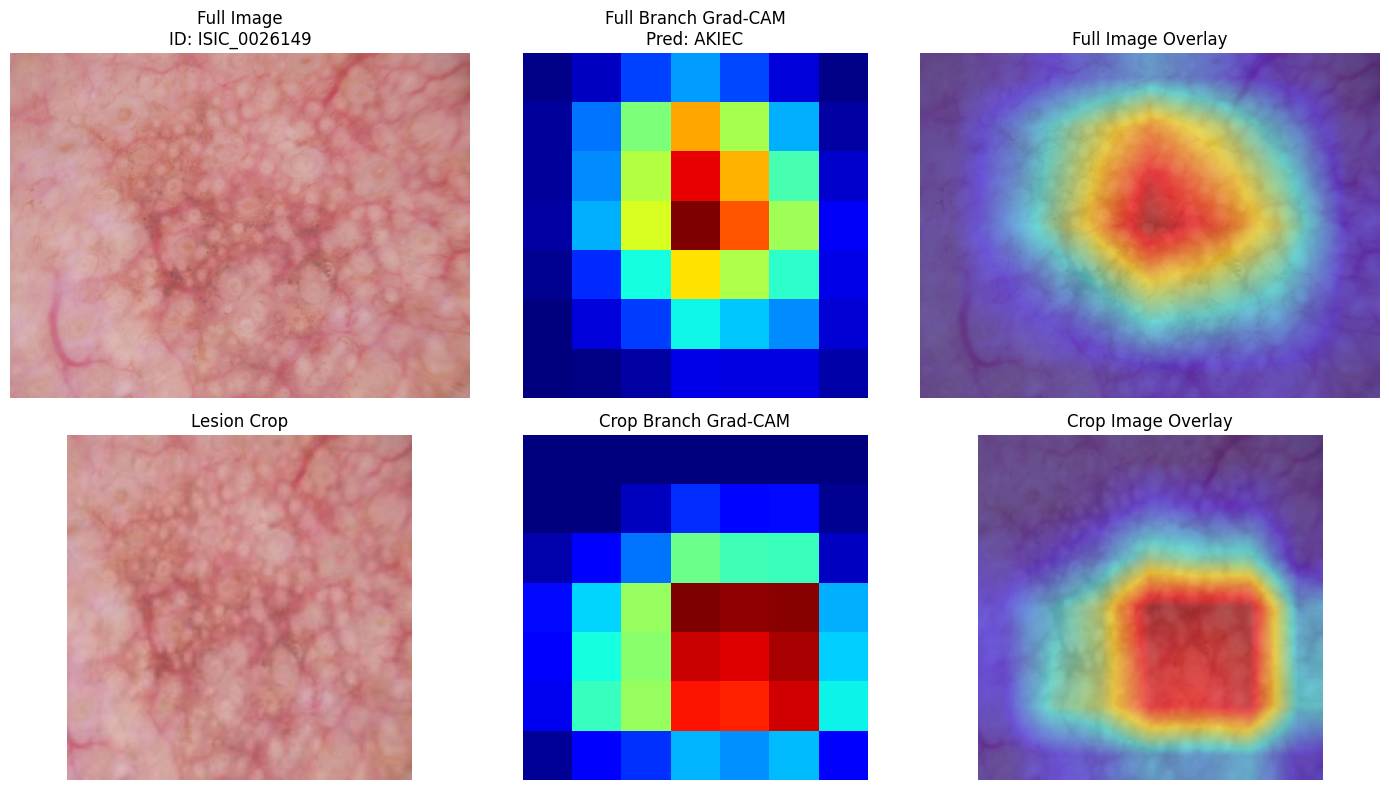

ID: ISIC_0027710


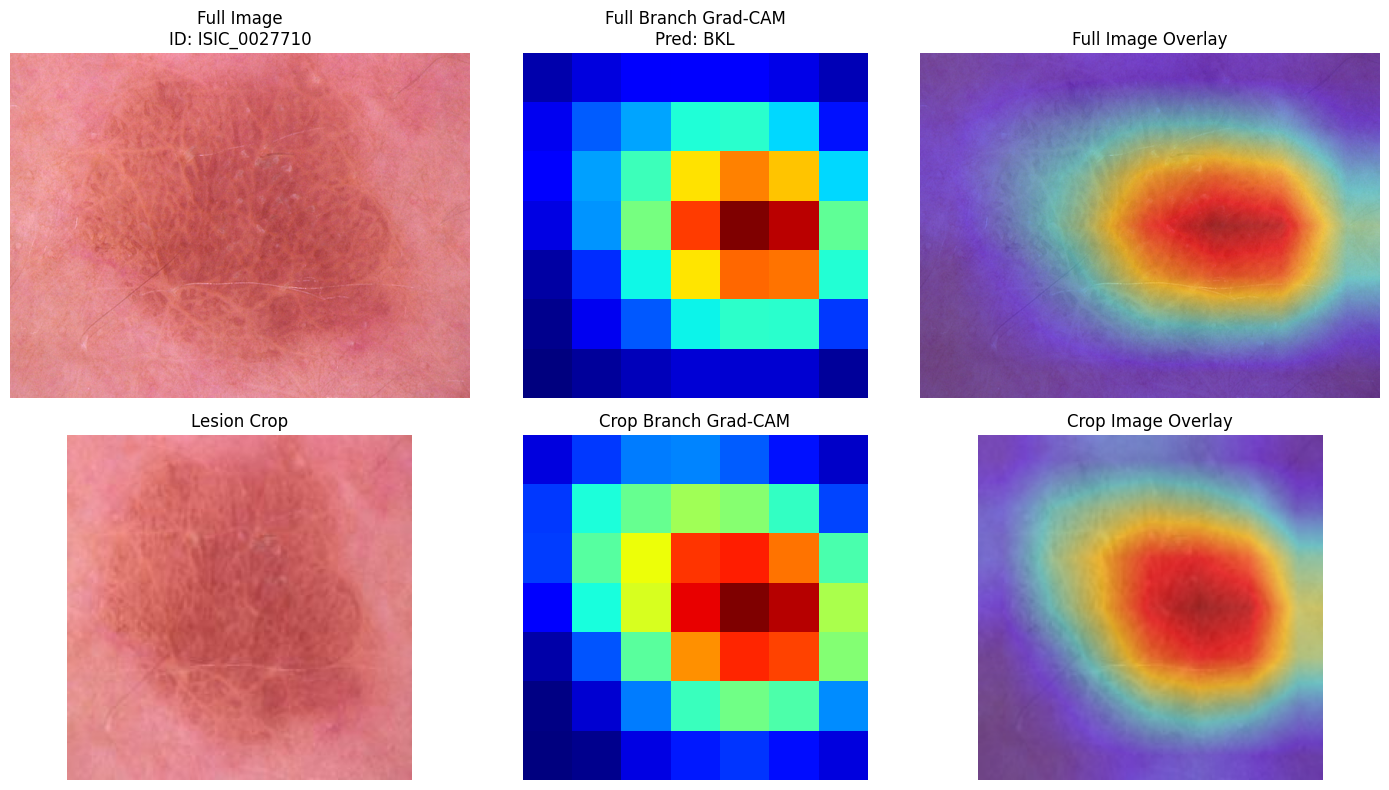

ID: ISIC_0028070


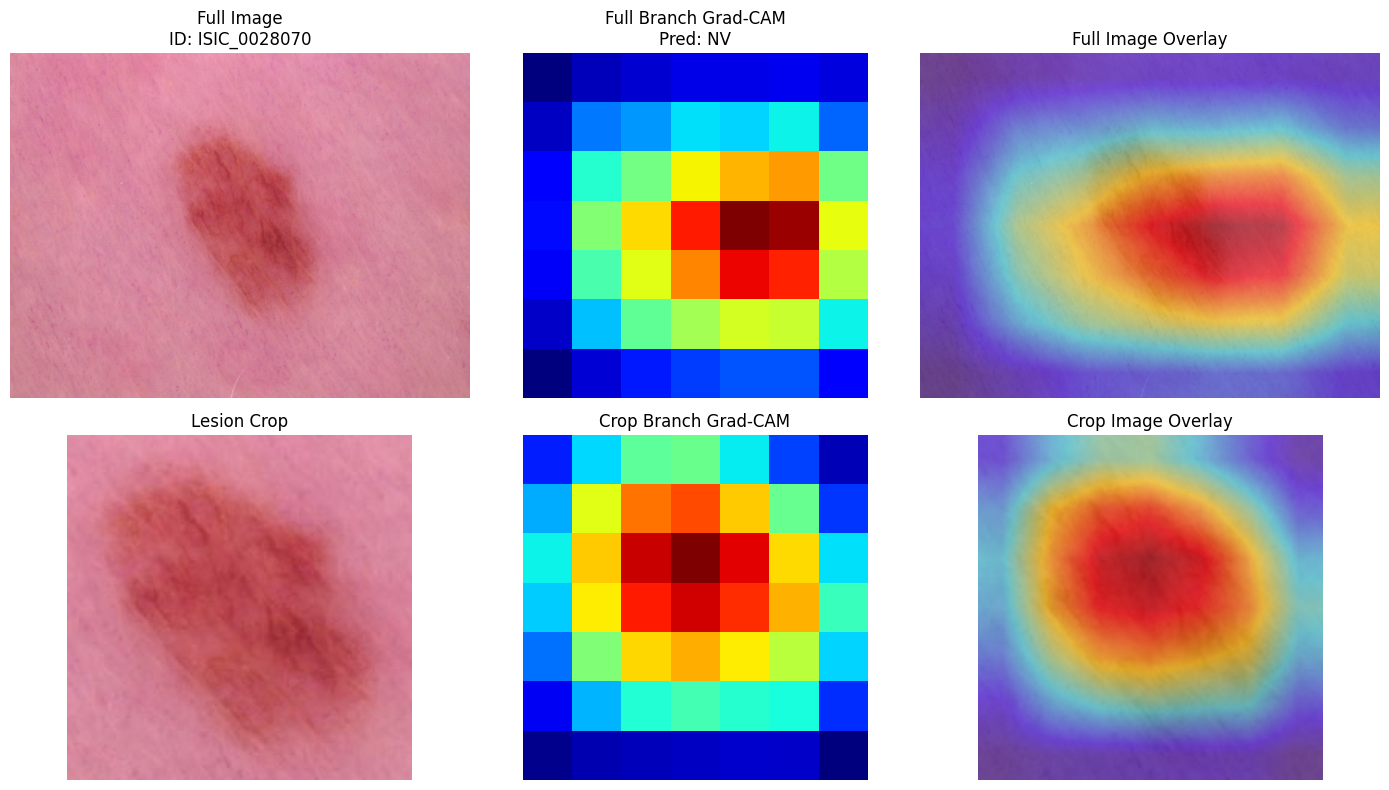

In [5]:
# Option 2: loop few random examples
for _ in range(3):
    img_id = random.choice(all_image_ids)
    print("ID:", img_id)
    visualize_gradcam_for_id(img_id)